In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import numpy as np
from scipy import stats
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#get the model results df: essay id, score_reg, score_demo, demographic value, demographic variable
def get_results_df(regular, demo):
  assert len(regular) == len(demo)
  regular = regular.rename(columns={'pred': 'pred_reg'})
  demo = demo.rename(columns={'pred': 'pred_demo'})
  merged = pd.merge(regular, demo, on='essay_id')
  merged.rename(columns={'demographic_value_x': 'demographic_value', 'demographic_variable_y': 'demographic_variable'}, inplace=True)
  return merged[['essay_id', 'pred_reg', 'pred_demo', 'demographic_variable','demographic_value']]

In [ ]:
llama_regular = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama_regular.csv')
llama_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama_demo_verbose.csv')
llama_results = get_results_df(llama_regular, llama_demo)
llama_results.head()

,essay_id,pred_reg,pred_demo,demographic_variable,demographic_value
0,2021000047,5,4,gender,F
1,2021000071,5,4,gender,M
2,2021000080,6,5,ell_status,No
3,2021000101,5,5,gender,M
4,2021000110,4,5,grade_level,8


In [ ]:

llama_instruct_regular = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama-instruct_regular_verbose.csv')
llama_instruct_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama-instruct_demo_verbose.csv')
llama_instruct_results = get_results_df(llama_instruct_regular, llama_instruct_demo)
llama_instruct_results.head()

,essay_id,pred_reg,pred_demo,demographic_variable,demographic_value
0,2021000047,4,5.0,gender,F
1,2021000071,3,3.0,gender,M
2,2021000080,4,4.0,ell_status,No
3,2021000101,3,4.0,gender,M
4,2021000110,3,3.0,grade_level,8


In [ ]:

qwen_regular = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/qwen_regular.csv')
qwen_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/qwen_demo_verbose.csv')
qwen_results = get_results_df(qwen_regular, qwen_demo)
qwen_results.head()

,essay_id,pred_reg,pred_demo,demographic_variable,demographic_value
0,2021000047,6,6.0,gender,F
1,2021000071,2,3.0,gender,M
2,2021000080,5,6.0,ell_status,No
3,2021000101,3,5.0,gender,M
4,2021000110,5,6.0,grade_level,8


In [ ]:
gemma_regular = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/gemma_regular_verbose.csv')
gemma_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/gemma_demo_verbose.csv')
gemma_results = get_results_df(gemma_regular, gemma_demo)
gemma_results.head()

,essay_id,pred_reg,pred_demo,demographic_variable,demographic_value
0,2021000047,1.0,3,gender,F
1,2021000071,1.0,2,gender,M
2,2021000080,1.0,3,ell_status,No
3,2021000101,1.0,1,gender,M
4,2021000110,1.0,2,grade_level,8


In [ ]:
flan_regular = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/flan-t5_regular_verbose.csv')
flan_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/flan-t5_demo_verbose.csv')
flan_results = pd.merge(flan_regular, flan_demo, on='essay_id', suffixes=('_reg', '_demo'), how='inner')
flan_results.rename(columns={'demographic_value_reg': 'demographic_value', 'demographic_variable_reg': 'demographic_variable'}, inplace=True)
flan_results = flan_results[['essay_id', 'pred_reg', 'pred_demo', 'demographic_variable','demographic_value']]
flan_results.head()

,essay_id,pred_reg,pred_demo,demographic_variable,demographic_value
0,2021000047,4.0,4.0,gender,F
1,2021000071,4.0,4.0,gender,M
2,2021000080,4.0,4.0,ell_status,No
3,2021000101,4.0,4.0,gender,M
4,2021000110,4.0,4.0,grade_level,8


In [ ]:
#given a model results df, get the average effect of
#adding any and real demo info

def get_effect(df):
  df['score_difference'] = df['pred_demo'] - df['pred_reg']
  overall_effect = df['score_difference'].mean()

  effects = {'Average Demo Effect': overall_effect}
  # Calculate effect for each demographic value
  for demo_value in df['demographic_value'].unique():
    #drop the grade idk
    if demo_value != '8' and demo_value != '9' and demo_value != '10' and demo_value != '11' and demo_value != '12':
      mask = df['demographic_value'] == demo_value
      effect = df.loc[mask, 'score_difference'].mean()
      effects[f'{demo_value}'] = effect

  # Convert to single-row DataFrame
  return pd.DataFrame([effects])


In [ ]:
get_effect(llama_results)

,Average Demo Effect,F,M,No,Not economically disadvantaged,Not identified as having disability,Hispanic/Latino,Economically disadvantaged,White,Black/African American,Identified as having disability,nan,Asian/Pacific Islander,Two or more races/Other,Yes,American Indian/Alaskan Native
0,-0.350534,-0.360856,-0.516717,0.019874,-0.236915,-0.466229,-0.296667,-0.441113,-0.462406,-0.231834,-0.293233,NaN,-0.11194,-0.215686,-0.141414,-0.666667


In [ ]:
model_results = {
    'Llama': llama_results,
    'Llama-Instruct': llama_instruct_results,
    'Qwen': qwen_results,
    'Gemma': gemma_results,
    'Flan-T5': flan_results
}

effects = {}

for model_name, df in model_results.items():
    effects[model_name] = get_effect(df)

all_effects = pd.concat(effects, ignore_index=False)

In [ ]:
all_effects

,,Average Demo Effect,F,M,No,Not economically disadvantaged,Not identified as having disability,Hispanic/Latino,Economically disadvantaged,White,Black/African American,Identified as having disability,nan,Asian/Pacific Islander,Two or more races/Other,Yes,American Indian/Alaskan Native
Llama,0,-0.350534,-0.360856,-0.516717,0.019874,-0.236915,-0.466229,-0.296667,-0.441113,-0.462406,-0.231834,-0.293233,NaN,-0.111940,-0.215686,-0.141414,-0.666667
Llama-Instruct,0,0.036477,-0.016820,0.071429,0.086721,-0.001377,0.045028,0.076667,0.042827,-0.024436,0.079585,-0.007519,NaN,-0.067164,-0.215686,0.141414,0.500000
Qwen,0,0.478769,0.542113,0.623100,0.620596,0.232782,0.517824,0.625418,0.396146,0.415414,0.560554,0.180451,NaN,0.276119,0.294118,0.121212,-0.333333
Gemma,0,1.901881,2.003058,1.735562,1.958446,2.057851,2.188555,1.910000,1.398287,1.776316,2.024221,1.586466,NaN,2.485075,2.000000,1.565657,1.666667
Flan-T5,0,0.226108,-0.052101,-0.035149,-0.052342,2.768466,-0.075962,-0.056940,-0.089325,-0.043222,-0.037915,-0.068702,NaN,-0.093750,-0.069767,-0.020202,0.000000


In [ ]:

models = [model for model, _ in all_effects.index.tolist()]
print(models)

['Llama', 'Llama-Instruct', 'Qwen', 'Gemma', 'Flan-T5']


DataFrame shape: (5, 16)

DataFrame columns: ['Average Demo Effect', 'F', 'M', 'No', 'Not economically disadvantaged', 'Not identified as having disability', 'Hispanic/Latino', 'Economically disadvantaged', 'White', 'Black/African American', 'Identified as having disability', 'nan', 'Asian/Pacific Islander', 'Two or more races/Other', 'Yes', 'American Indian/Alaskan Native']

DataFrame index: [('Llama', 0), ('Llama-Instruct', 0), ('Qwen', 0), ('Gemma', 0), ('Flan-T5', 0)]


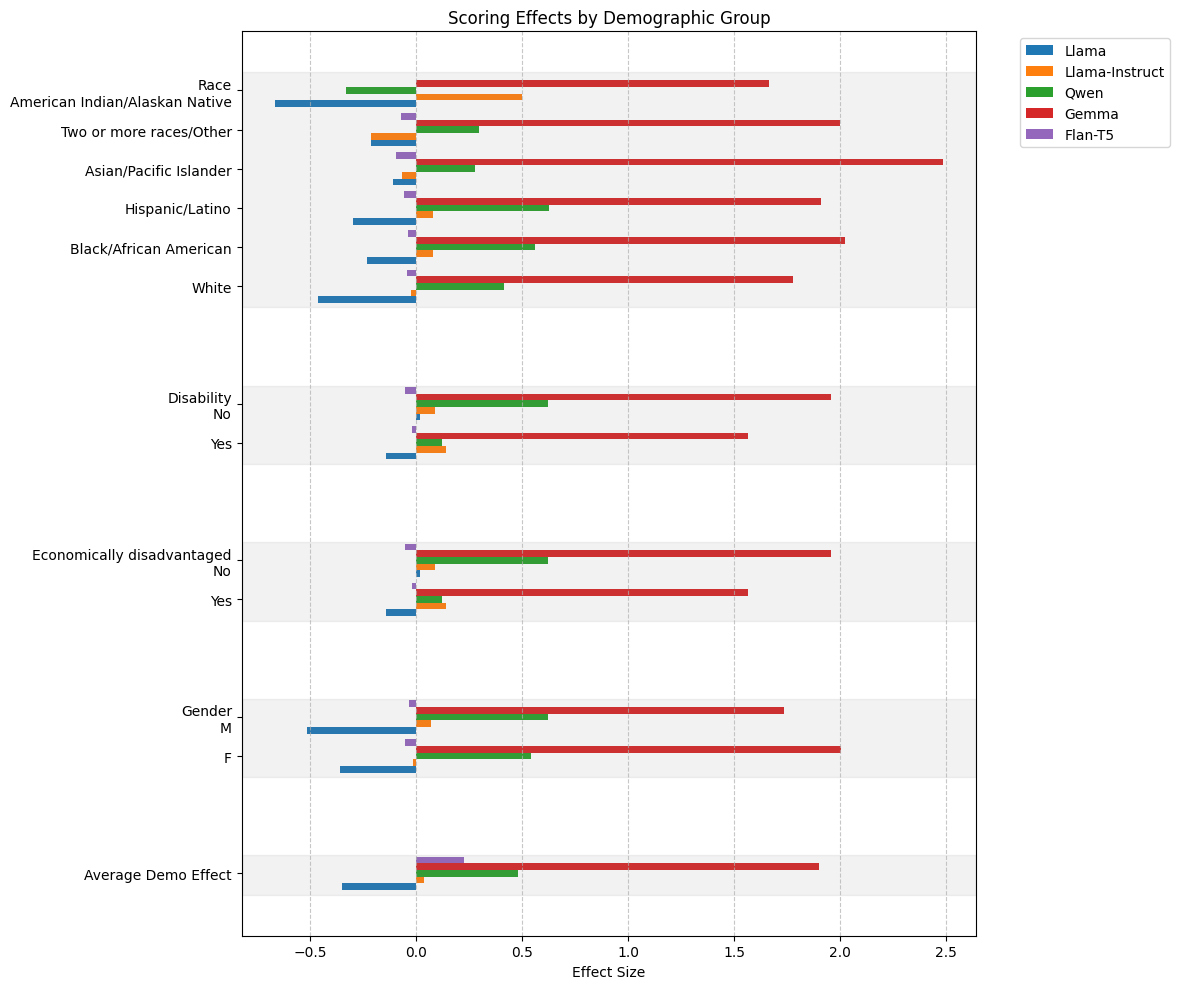

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_demographic_effects(df):
    models = [model for model, _ in df.index.tolist()]

    fig, ax = plt.subplots(figsize=(12, 10))

    groups = {
        'Average': ['Average Demo Effect'],
        'Gender': ['F', 'M'],
        'Economically disadvantaged': ['Economically disadvantaged', 'Not economically disadvantaged'],
        'Disability': ['Identified as having disability', 'Not identified as having disability'],
        'Race': ['White', 'Black/African American', 'Hispanic/Latino', 'Asian/Pacific Islander', 'Two or more races/Other','American Indian/Alaskan Native']
    }

    y_positions = []
    y_labels = []
    group_positions = []
    group_names = []
    current_pos = 0

    valid_groups = {}
    for group_name, variables in groups.items():
        valid_vars = [var for var in variables if var in df.columns]
        if valid_vars:
            valid_groups[group_name] = valid_vars

    group_boundaries = []
    for group_name, variables in valid_groups.items():
        group_boundaries.append((current_pos, group_name,len(variables)))
        group_start = current_pos
        for var in variables:
            y_positions.append(current_pos)
            if group_name == 'Economically disadvantaged' or group_name == 'Disability':
                if var == 'Economically disadvantaged':
                    y_labels.append('Yes')
                elif var == 'Not economically disadvantaged':
                    y_labels.append('No')
                if var == 'Identified as having disability':
                    y_labels.append('Yes')
                elif var == 'Not identified as having disability':
                    y_labels.append('No')

            else:
              y_labels.append(var)
            current_pos += 1

        group_middle = (group_start + current_pos - 1) / 2
        group_positions.append(group_middle)
        group_names.append(group_name)

        current_pos += 2  s

    bar_width = 0.17
    for i, model_name in enumerate(models):
        model_idx = (model_name, 0)
        values = []
        for var in y_labels:
            val = df.loc[model_idx, var]
            if isinstance(val, (np.ndarray, pd.Series)):
                val = float(val.iloc[0] if hasattr(val, 'iloc') else val[0])
            values.append(val)

        ax.barh([pos + i * bar_width for pos in y_positions],
                values,
                height=bar_width,
                label=model_name)

    ax.set_yticks([pos + bar_width * 2 for pos in y_positions])
    ax.set_yticklabels(y_labels)

    y_tick_labels = []
    current_idx = 0
    for boundary, group_name, group_size in group_boundaries:
        for i in range(group_size):
            if i == group_size-1 and group_name != "Average":  # First item in group
                y_tick_labels.append(f"{group_name}\n{y_labels[current_idx]}")
            else:
                y_tick_labels.append(y_labels[current_idx])
            current_idx += 1

    ax.set_yticklabels(y_tick_labels)

    for boundary, _, group_size in group_boundaries:
        ax.axhspan(
            boundary - 0.2,  # Start of group
            boundary + group_size - 0.2,  # End of group
            color='gray',
            alpha=0.1
        )

    ax.set_xlabel('Effect Size')
    ax.set_title('Model Effects by Demographic Group')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    ax.set_xlabel('Effect Size')
    ax.set_title('Scoring Effects by Demographic Group')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.margins(y=0.05)
    plt.tight_layout()

    return fig

fig = plot_demographic_effects(all_effects)
plt.show()

In [ ]:
real_demo_effects = all_effects.copy()
real_demo_effects.head()

,,Average Demo Effect,F,M,No,Not economically disadvantaged,Not identified as having disability,Hispanic/Latino,Economically disadvantaged,White,Black/African American,Identified as having disability,nan,Asian/Pacific Islander,Two or more races/Other,Yes,American Indian/Alaskan Native
Llama,0,-0.350534,-0.360856,-0.516717,0.019874,-0.236915,-0.466229,-0.296667,-0.441113,-0.462406,-0.231834,-0.293233,NaN,-0.111940,-0.215686,-0.141414,-0.666667
Llama-Instruct,0,0.036477,-0.016820,0.071429,0.086721,-0.001377,0.045028,0.076667,0.042827,-0.024436,0.079585,-0.007519,NaN,-0.067164,-0.215686,0.141414,0.500000
Qwen,0,0.478769,0.542113,0.623100,0.620596,0.232782,0.517824,0.625418,0.396146,0.415414,0.560554,0.180451,NaN,0.276119,0.294118,0.121212,-0.333333
Gemma,0,1.901881,2.003058,1.735562,1.958446,2.057851,2.188555,1.910000,1.398287,1.776316,2.024221,1.586466,NaN,2.485075,2.000000,1.565657,1.666667
Flan-T5,0,0.226108,-0.052101,-0.035149,-0.052342,2.768466,-0.075962,-0.056940,-0.089325,-0.043222,-0.037915,-0.068702,NaN,-0.093750,-0.069767,-0.020202,0.000000


In [ ]:
llama_cf = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama_demo_cf.csv')
llama_demo = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama_demo_verbose.csv')
llama_cf_results = get_results_df(llama_cf, llama_demo)
llama_cf_results.head()

AssertionError: 

In [ ]:
llama_cf = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama-instruct_demo_cf.csv')
llama_instruct_cf = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/llama-instruct_demo_cf.csv')
qwen_cf= pd.read_csv('/content/drive/MyDrive/COS597H/outputs/qwen_demo_cf.csv')
gemma_cf = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/gemma_demo_cf.csv')
flan_cf = pd.read_csv('/content/drive/MyDrive/COS597H/outputs/flan-t5_demo_cf.csv')

In [ ]:
llama_cf_results =pd.concat([llama_cf, llama_demo]).drop_duplicates()
llama_instruct_cf_results =pd.concat([llama_instruct_cf, llama_demo]).drop_duplicates()
qwen_cf_results =pd.concat([qwen_cf, llama_demo]).drop_duplicates()
gemma_cf_results =pd.concat([gemma_cf, llama_demo]).drop_duplicates()
flan_cf_results =pd.concat([flan_cf, llama_demo]).drop_duplicates()

In [ ]:
llama_cf_results.head()

,essay_id,demographic_value,pred,Unnamed: 0,demographic_variable
0,2421003804,F,4,NaN,NaN
1,AAAXMP138200001747842810_OR,F,4,NaN,NaN
2,2091005358,M,4,NaN,NaN
3,AAAXMP138200001989812810_OR,F,4,NaN,NaN
4,AAAXMP138200001241242125_OR,M,4,NaN,NaN


In [ ]:
#average score for all students - average score for for all essays with a white demographic value
def diff_in_averages(df):
  overall_avg = df['pred'].mean()
  demographic_means = df.groupby('demographic_value')['pred'].agg([
      ('group_avg', 'mean'),
      ('count', 'size')
  ]).reset_index()

  demographic_means['gap'] = overall_avg - demographic_means['group_avg']
  demographic_means['overall_avg'] = overall_avg

  result = demographic_means[[
      'demographic_value',
      'group_avg',
      'overall_avg',
      'gap',
      'count'
  ]]

  return result

In [ ]:
diff_in_averages(llama_cf_results)

,demographic_value,group_avg,overall_avg,gap,count
0,10,3.897788,4.116787,0.218999,1311
1,11,3.957285,4.116787,0.159502,1311
2,12,3.948894,4.116787,0.167893,1311
3,8,4.346301,4.116787,-0.229514,1311
4,9,3.817696,4.116787,0.299090,1311
5,American Indian/Alaskan Native,3.999238,4.116787,0.117549,1312
6,Asian/Pacific Islander,4.033537,4.116787,0.083250,1312
7,Black/African American,4.113567,4.116787,0.003220,1312
8,Economically disadvantaged,4.180015,4.116787,-0.063228,1311
9,F,4.253049,4.116787,-0.136262,1312
